<a href="https://www.kaggle.com/code/saswattulo/pytorch-intel-image-classification?scriptVersionId=192827341" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


import torch
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import shutil

from PIL import Image
import requests
from io import BytesIO

device="cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_dir='/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir='/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_dir='/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [3]:
train_data_transforms=transforms.Compose([transforms.Resize(size=(128,128)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.RandomVerticalFlip(p=0.5),
                                         transforms.ToTensor()])
test_data_transforms=transforms.Compose([transforms.Resize(size=(128,128)),
                                         transforms.ToTensor()])

In [4]:
train_folder=ImageFolder(root=train_dir,
                         transform=train_data_transforms,
                         target_transform=None)
test_folder=ImageFolder(root=test_dir,
                        transform=test_data_transforms)

classes_name=train_folder.classes
print(classes_name)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [5]:
train_data_loader=DataLoader(dataset=train_folder,
                             batch_size=32,
                             shuffle=True)
test_data_loader=DataLoader(dataset=test_folder,
                            batch_size=32,
                            shuffle=False)

In [6]:
len(train_data_loader),len(test_data_loader)

(439, 94)

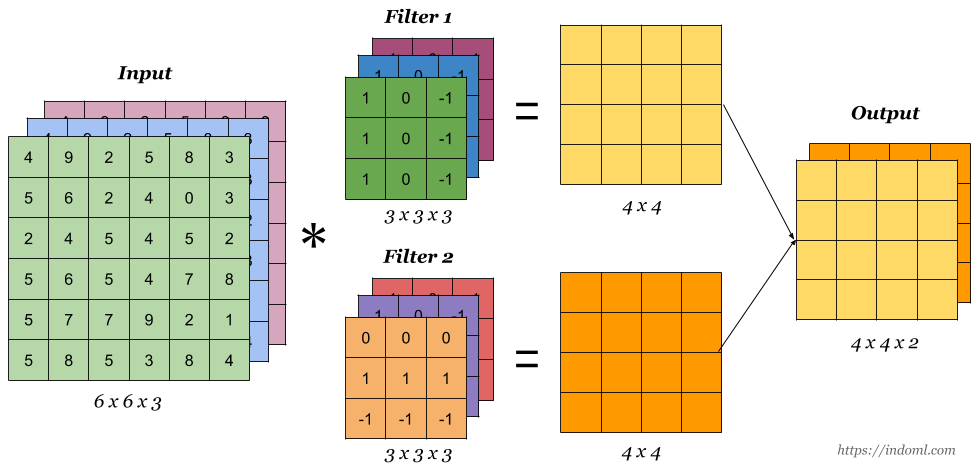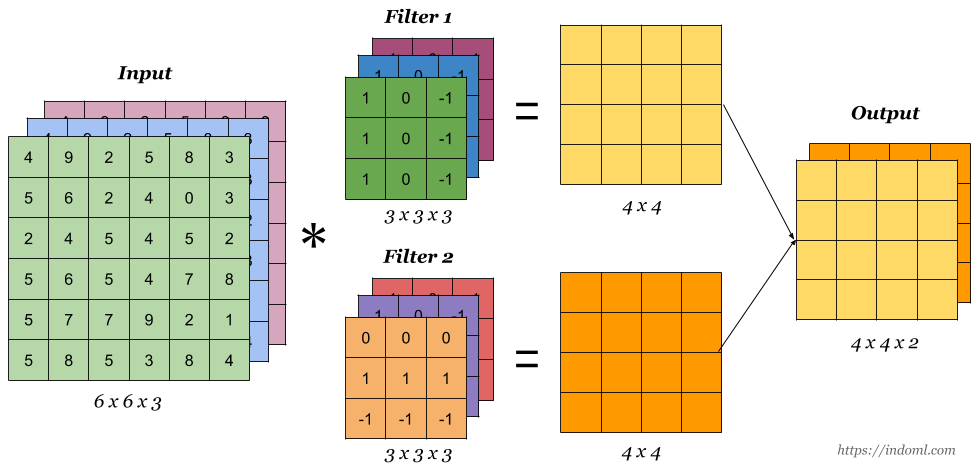

In [7]:
class TinyVGG(nn.Module):
    def __init__(self,input_size:int,output_size:int,hidden_units:int):
        super().__init__()
        self.block_1=nn.Sequential(nn.Conv2d(in_channels=input_size,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=0,stride=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3,stride=1))
        self.block_2=nn.Sequential(nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3,stride=1))
        self.classifier_block=nn.Sequential(nn.Flatten(),
                                            nn.Linear(in_features=13456*hidden_units,out_features=output_size))
        
    def forward(self,x):
        x=self.block_1(x)
#         print(x.shape)
        x=self.block_2(x)
#         print(x.shape)
        x=self.classifier_block(x)
#         print(x.shape)
        return x

In [8]:
weather_classifier=TinyVGG(input_size=3,hidden_units=32,output_size=len(classes_name))
img,label=next(iter(train_data_loader))
summary(model=weather_classifier,input_data=img,batch_dim=32)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 6]                   --
├─Sequential: 1-1                        [32, 32, 122, 122]        --
│    └─Conv2d: 2-1                       [32, 32, 126, 126]        896
│    └─ReLU: 2-2                         [32, 32, 126, 126]        --
│    └─Conv2d: 2-3                       [32, 32, 124, 124]        9,248
│    └─ReLU: 2-4                         [32, 32, 124, 124]        --
│    └─MaxPool2d: 2-5                    [32, 32, 122, 122]        --
├─Sequential: 1-2                        [32, 32, 116, 116]        --
│    └─Conv2d: 2-6                       [32, 32, 120, 120]        9,248
│    └─ReLU: 2-7                         [32, 32, 120, 120]        --
│    └─Conv2d: 2-8                       [32, 32, 118, 118]        9,248
│    └─ReLU: 2-9                         [32, 32, 118, 118]        --
│    └─MaxPool2d: 2-10                   [32, 32, 116, 116]        --
├─Seq

In [9]:
img,label=next(iter(train_data_loader))

In [10]:
def train_step(model:nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               optimizer:torch.optim,
               loss_function:nn.Module,
               device:torch.device=device):
    
    # put the model into device
    model=model.to(device)
    
    # activate train mode
    model.train()
    
    # set up model metrics
    training_acc,training_loss=0,0
    
    # iterate through the batches of train dataloader
    for batch,(X,y) in enumerate(train_data_loader):
        
        # put X and y into given hardware device
        X=X.to(device)
        y=y.to(device)
        
        # forward pass
        y_pred=model(X)
        
        # calculate the training loss
        train_loss=loss_function(y_pred,y)
        training_loss+=train_loss.item()
        
        # zero grad the optimizer
        optimizer.zero_grad()
        
        # backward propagation
        train_loss.backward()
        
        # parameter updation
        optimizer.step()
        
        # calculate the accuracy
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        training_acc+=(y_pred_class==y).sum().item()/len(y)
        
    # adjust the training metrics for batchs
    training_acc/=len(train_dataloader)
    training_loss/=len(train_dataloader)
    
    return training_loss,training_acc

In [11]:
def test_step(model:nn.Module,
              loss_function:nn.Module,
              test_dataloader:torch.utils.data.DataLoader,
              device:torch.device=device):
    
    # put the model into the desired device
    model=model.to(device)
    
    # set up model evaluate metrics
    testing_acc=0
    testing_loss=0
    
    # activate eval
    model.eval()
    
    with torch.inference_mode():
        # iterration starts here
        for batch,(X,y) in enumerate(test_data_loader):

            # put the X and y into given device
            X=X.to(device)
            y=y.to(device)

            # forward propagation
            y_pred=model(X)

            # calculate test_loss
            test_loss=loss_function(y_pred,y)
            testing_loss+=test_loss.item()

            y_pred_class=y_pred.argmax(dim=1)

            testing_acc+=(y_pred_class==y).sum().item()/len(y)
        
    
    # adjust the metrics
    testing_acc=testing_acc/len(test_data_loader)
    testing_loss=testing_loss/len(test_data_loader)
    
    return testing_loss,testing_acc

In [12]:
from tqdm.auto import tqdm

def train(model:nn.Module,
                  train_dataloader:torch.utils.data.DataLoader,
                  test_dataloader:torch.utils.data.DataLoader,
                  optimizer:torch.optim,
                  loss_function:nn.Module,
                  epochs:int=3,
                  device:torch.device=device):
    
    # create empty results dictionary
    results={"training_loss":[],
            "training_acc":[],
            "testing_loss":[],
            "testing_acc":[]
           }
    
    
    for epoch in tqdm(range(epochs),desc="Model training in progress"):
        # train the model
        train_loss,train_acc=train_step(model=model,
                                        train_dataloader=train_data_loader,
                                        optimizer=optimizer,
                                        loss_function=loss_function,
                                        device=device)

        # test the model
        test_loss,test_acc=test_step(model=model,
                                     test_dataloader=test_data_loader,
                                     loss_function=loss_function,
                                     device=device)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
    
        results['training_loss'].append(train_loss)
        results['training_acc'].append(train_acc)
        results['testing_loss'].append(test_loss)
        results['testing_acc'].append(test_acc)
    
    return results

In [13]:
# creating a model
model=TinyVGG(input_size=3,hidden_units=16,output_size=len(classes_name)).to(device)

# optimizer
optimizer=torch.optim.Adagrad(params=model.parameters(),lr=0.01)

# loss function
loss_function=nn.CrossEntropyLoss()

epochs=80

In [14]:
results=train(model=model,
      train_dataloader=train_data_loader,
      test_dataloader=test_data_loader,
      loss_function=loss_function,
      optimizer=optimizer,device=device,epochs=epochs)

Model training in progress:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9744 | train_acc: 0.1782 | test_loss: 1.7906 | test_acc: 0.1745
Epoch: 2 | train_loss: 1.7909 | train_acc: 0.1791 | test_loss: 1.7904 | test_acc: 0.1745
Epoch: 3 | train_loss: 1.7909 | train_acc: 0.1790 | test_loss: 1.7903 | test_acc: 0.1745
Epoch: 4 | train_loss: 1.7908 | train_acc: 0.1789 | test_loss: 1.7902 | test_acc: 0.1745
Epoch: 5 | train_loss: 1.7908 | train_acc: 0.1789 | test_loss: 1.7902 | test_acc: 0.1745
Epoch: 6 | train_loss: 1.7908 | train_acc: 0.1791 | test_loss: 1.7902 | test_acc: 0.1745
Epoch: 7 | train_loss: 1.7908 | train_acc: 0.1790 | test_loss: 1.7902 | test_acc: 0.1745
Epoch: 8 | train_loss: 1.7908 | train_acc: 0.1789 | test_loss: 1.7902 | test_acc: 0.1745
Epoch: 9 | train_loss: 1.7908 | train_acc: 0.1789 | test_loss: 1.7901 | test_acc: 0.1745
Epoch: 10 | train_loss: 1.7908 | train_acc: 0.1789 | test_loss: 1.7901 | test_acc: 0.1745
Epoch: 11 | train_loss: 1.7908 | train_acc: 0.1788 | test_loss: 1.7901 | test_acc: 0.1745
Epoch: 12 | train_l

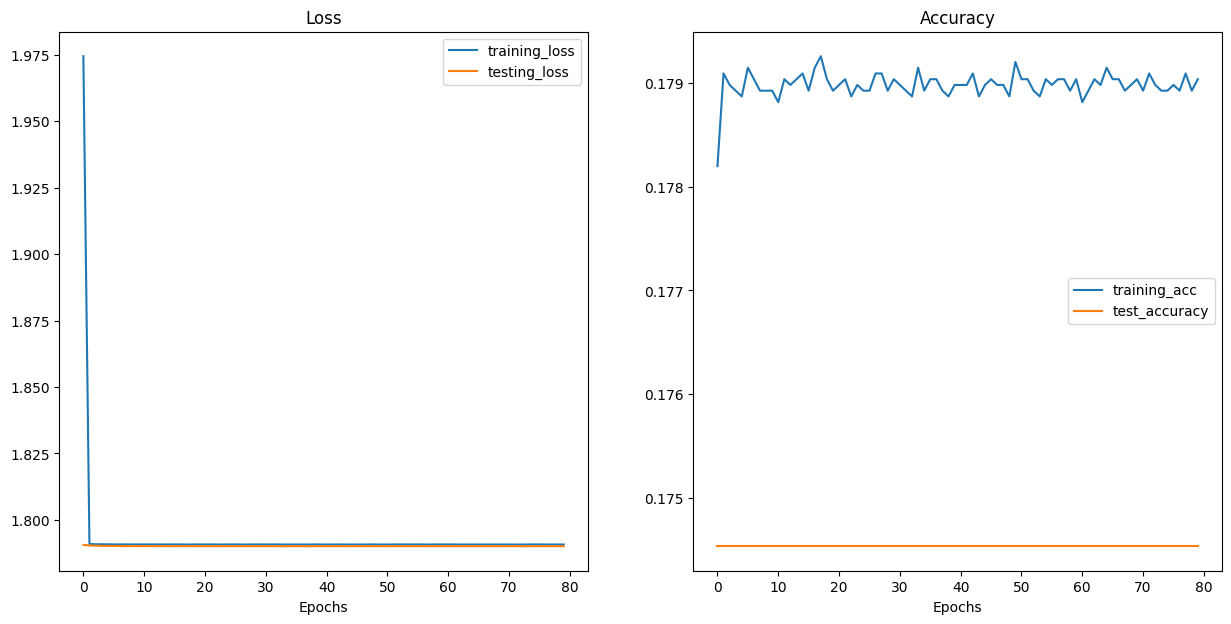

In [15]:
from typing import Tuple,List,Dict

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"training_loss": [...],
             "training_acc": [...],
             "testing_loss": [...],
             "testing_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['training_loss']
    test_loss = results['testing_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['training_acc']
    test_accuracy = results['testing_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['training_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, test_loss, label='testing_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_acc')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_loss_curves(results)